# Importation des bibliothèques nécessaires

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import seaborn as sn
from sklearn.model_selection import train_test_split

# Chargements des données

In [4]:
# Constants
IMG_SIZE = 128
BATCH_SIZE = 32

# Fonction pour charger les données
def load_data():
    """Charge les données de malaria depuis tensorflow_datasets"""
    dataset_name = "malaria"
    (train_data, test_data), metadata = tfds.load(
        dataset_name,
        split=["train[:80%]", "train[80%:]"],
        as_supervised=True,
        with_info=True
    )
    return train_data, test_data, metadata

# Charger le dataset avec metadata
(train_dataset, test_dataset, info) = load_data()

# Calculer le nombre d'exemples pour le split
num_train_examples = int(info.splits['train'].num_examples * 0.8)
num_validation_examples = int(info.splits['train'].num_examples * 0.2)

print("Dataset Info:")
print(info)
print(f"Nombre d'exemples dans le dataset d'entraînement: {num_train_examples}")
print(f"Nombre d'exemples dans le dataset de validation: {num_validation_examples}")

Dataset Info:
tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='C:\\Users\\Utilisateur\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria paras

# Préparation des données

Visualisation des exemples du dataset d'entraînement:


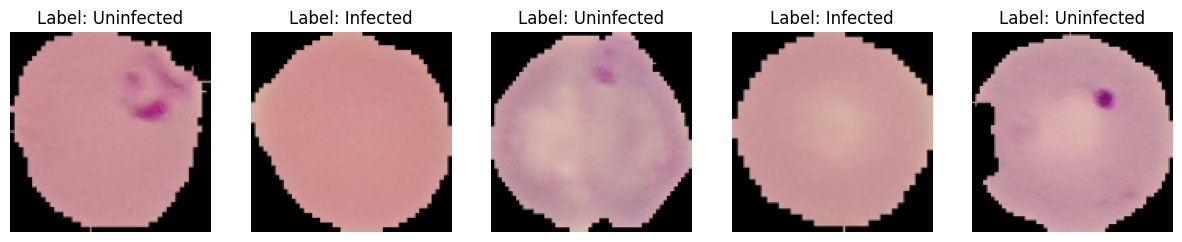

In [5]:
# Prétraitement des données
def preprocess(image, label):
    """Redimensionne et normalise les images"""
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0  # Normalisation entre 0 et 1
    return image, label

train_dataset = train_dataset.map(preprocess).batch(BATCH_SIZE).shuffle(1000)
test_dataset = test_dataset.map(preprocess).batch(BATCH_SIZE)

# Visualisation de quelques exemples
def visualize_data(dataset, num_images=5):
    """Affiche quelques exemples du dataset"""
    plt.figure(figsize=(15, 15))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(image.numpy())
        plt.title(f"Label: {'Infected' if label.numpy() == 1 else 'Uninfected'}")
        plt.axis('off')
    plt.show()

print("Visualisation des exemples du dataset d'entraînement:")
visualize_data(train_dataset.unbatch())

# Construction et compilation du modèle

In [6]:

# Créer le modèle CNN
model = tf.keras.Sequential([
tf.keras.Input(shape=(128, 128, 3)),  # Taille de l'image 128x128 avec 3 canaux couleur (RGB)
tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),  # Première couche convolutionnelle
tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # Pooling pour réduire la taille de l'image

tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Deuxième couche convolutionnelle
tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # Pooling pour réduire la taille de l'image

tf.keras.layers.Flatten(),  # Flatten pour transformer les données en vecteur
tf.keras.layers.Dropout(0.7),  # Dropout pour éviter le surapprentissage

tf.keras.layers.Dense(128, activation='relu'),  # Couche dense avec activation ReLU
tf.keras.layers.Dense(1, activation='sigmoid')  # Couche de sortie pour la classification binaire
    ])

    # Compiler le modèle
model.compile(optimizer='adam',  # Optimiseur Adam
            loss='binary_crossentropy',  # Fonction de perte pour une classification binaire
            metrics=['accuracy', 'precision', 'recall'])  # Métriques à surveiller


# Afficher le résumé du modèle
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,449 (28.20 MB)

 Trainable params: 7,392,449 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

# Entraînement du modèle

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 227s 323ms/step - accuracy: 0.6578 - loss: 0.6048 - precision: 0.6463 - recall: 0.6973 - val_accuracy: 0.9229 - val_loss: 0.2787 - val_precision: 0.8976 - val_recall: 0.9531
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 221s 316ms/step - accuracy: 0.9288 - loss: 0.2092 - precision: 0.9181 - recall: 0.9429 - val_accuracy: 0.9294 - val_loss: 0.2315 - val_precision: 0.9103 - val_recall: 0.9513
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 215s 306ms/step - accuracy: 0.9433 - loss: 0.1690 - precision: 0.9428 - recall: 0.9433 - val_accuracy: 0.9458 - val_loss: 0.1954 - val_precision: 0.9448 - val_recall: 0.9458
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 224s 319ms/step - accuracy: 0.9477 - loss: 0.1582 - precision: 0.9419 - recall: 0.9560 - val_accuracy: 0.9441 - val_loss: 0.1808 - val_precision: 0.9262 - val_recall: 0.9641
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 236s 337ms/step - accuracy: 0.9538 - loss: 0.1423 - precision: 0.9468 - recall: 0.9628 - val_accuracy: 0

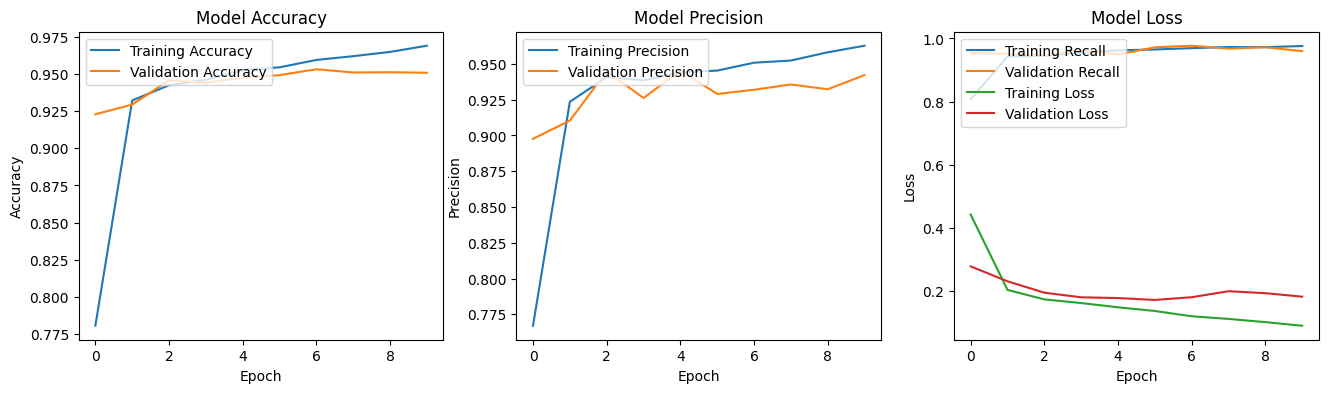

In [8]:
# Préparer les données
train_dataset, validation_dataset = train_dataset, test_dataset

# Entraîner le modèle
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

# Visualiser l'évolution des performances
plt.figure(figsize=(16, 4))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Precision
plt.subplot(1, 3, 2)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(loc='upper left')

# Recall
plt.subplot(1, 3, 3)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(loc='upper left')

# Loss
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

In [9]:
import keras.saving

keras.saving.save_model(model, "/app/model/malaria_model.keras")

# Visualisations de quelques prédictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━

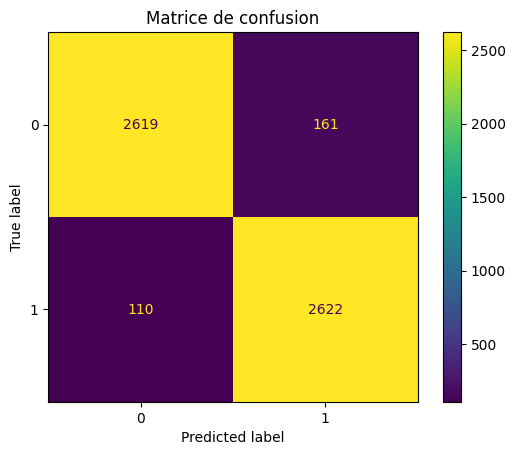

Rapport de classification :
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2780
           1       0.94      0.96      0.95      2732

    accuracy                           0.95      5512
   macro avg       0.95      0.95      0.95      5512
weighted avg       0.95      0.95      0.95      5512



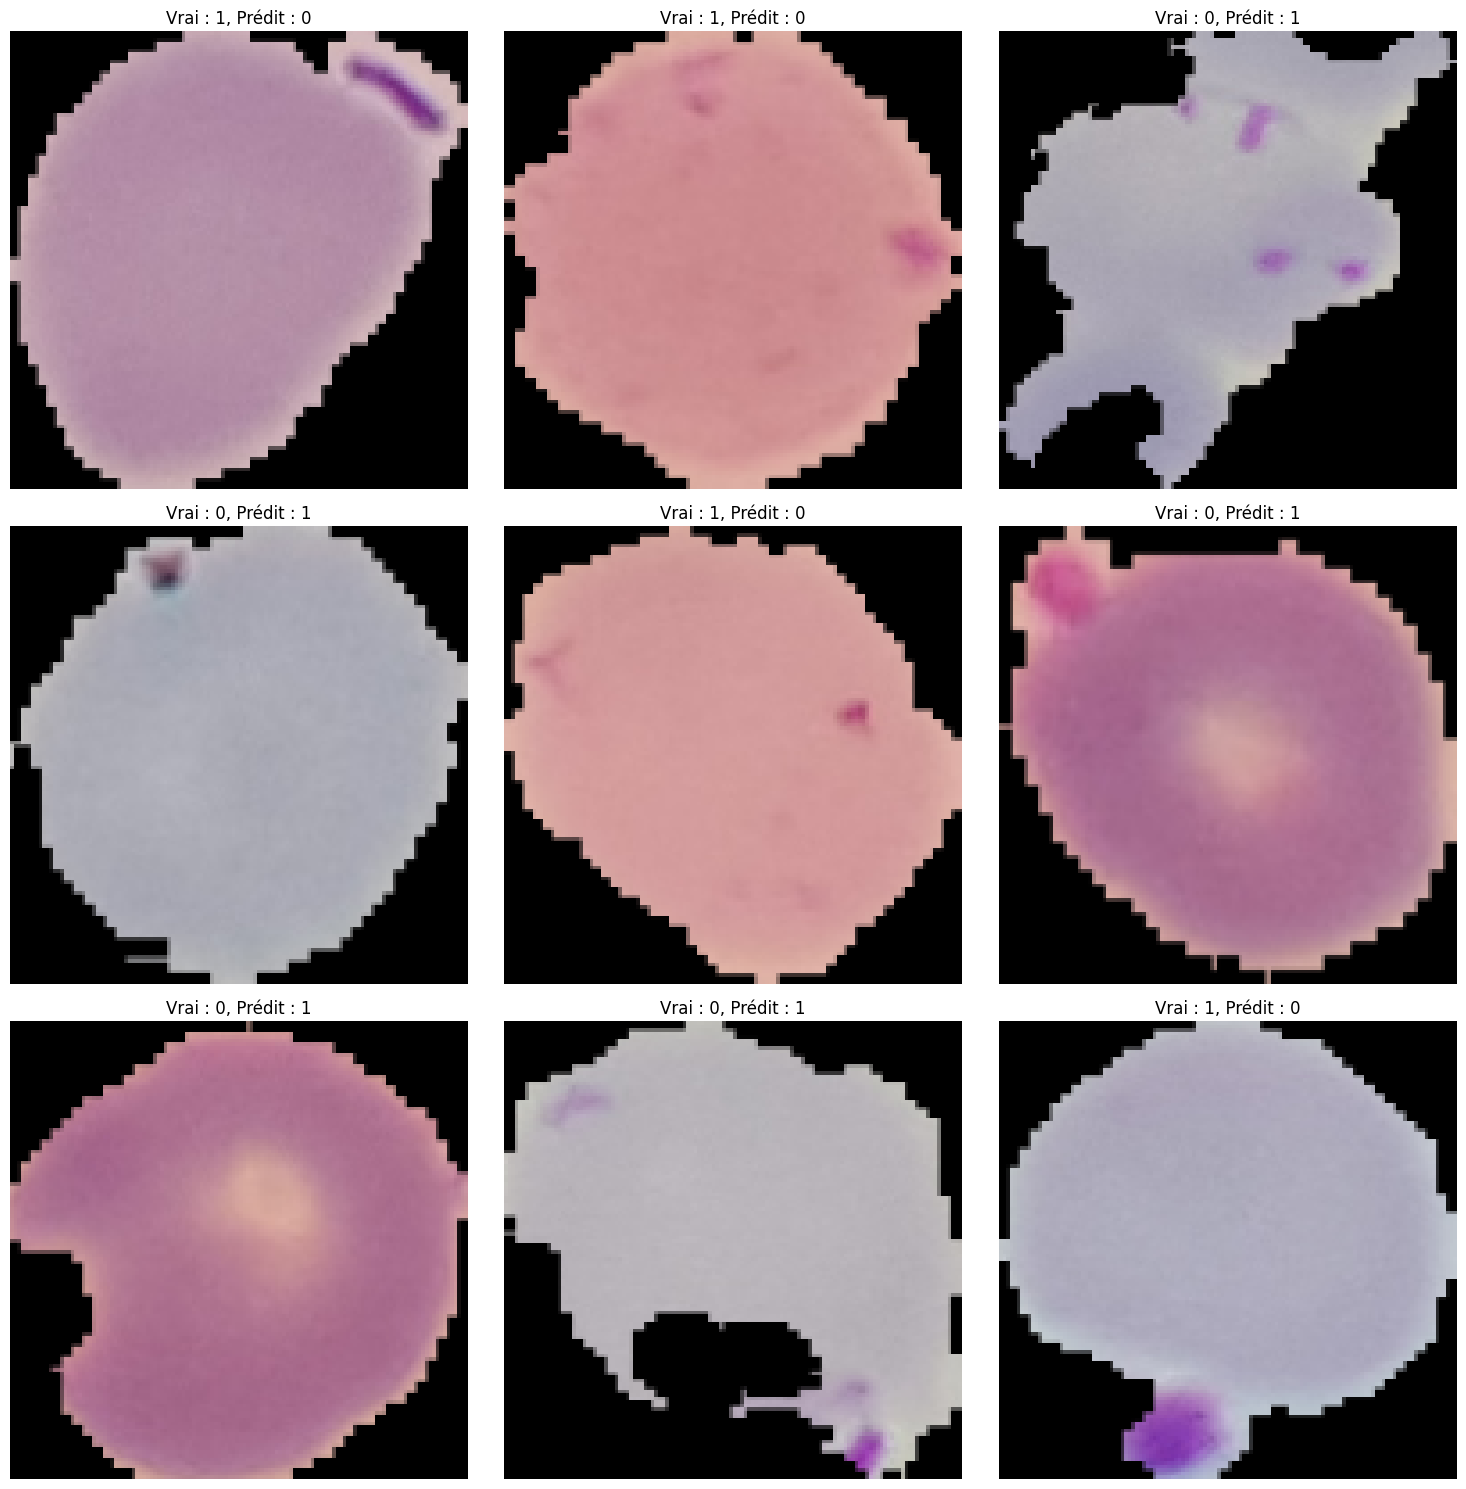

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Chargement du modèle
model = tf.keras.models.load_model("/app/model/malaria_model.keras")

# Génération des prédictions
predictions = np.concatenate([model.predict(batch[0]) for batch in test_dataset], axis=0)

# Extraction des labels réels
true_classes = np.concatenate([batch[1].numpy() for batch in test_dataset], axis=0)

# Vérification des dimensions
print("Forme de predictions :", predictions.shape)
print("Forme de true_classes :", true_classes.shape)

# Si les labels ne sont pas one-hot (i.e., sous forme d'entiers), ajuster le code
if len(true_classes.shape) == 1:
    # Labels sous forme d'entiers
    y_true = true_classes
else:
    # Labels sous forme one-hot
    y_true = np.argmax(true_classes, axis=1)

# Obtenir les classes prédites avec un seuil de 0.5
y_pred = (predictions > 0.5).astype(int)

# Matrice de confusion
confusion_mat = confusion_matrix(y_true, y_pred)
print("Matrice de confusion :")
print(confusion_mat)

# Affichage de la matrice de confusion
ConfusionMatrixDisplay(confusion_matrix=confusion_mat).plot(cmap="viridis")
plt.title("Matrice de confusion")
plt.show()

# Rapport de classification
classification_rep = classification_report(y_true, y_pred)
print("Rapport de classification :")
print(classification_rep)

# Visualisation des erreurs
# Extraction des images et des labels pour les indices erronés
errors = np.where(y_true != y_pred.ravel())[0]  # Adapter pour des labels binaires (seuil)
images, true_labels = zip(*[(img.numpy(), label.numpy()) for img, label in test_dataset.unbatch()])

# Affichage des erreurs
plt.figure(figsize=(15, 15))
for i, idx in enumerate(errors[:9]):  # Limitez à 9 exemples pour éviter un affichage trop dense
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[idx], cmap="gray")
    plt.title(f"Vrai : {true_labels[idx]}, Prédit : {y_pred[idx][0]}")
    plt.axis("off")

plt.tight_layout()
plt.show()